## Data preparation and vectorization

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


Data = np.zeros((400,10304))
cnt=0
paths = ["archive/s"+str(i) for i in range(1,41)]
# looping through the paths and adding flattened images (row matrices) to the Data matrix
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt]=np_img
        cnt+=1

# creating the labels vector
labels = np.zeros((400,1))
for i in range(1,41):
    labels[(i-1)*10:i*10] = i

# creating the training set and test set
# syntax explanation : [beginning:end:step]
training_set = Data[0:400:2]
test_set = Data[1:400:2]

# creating the training labels and test labels
training_labels = labels[0:400:2]
test_labels = labels[1:400:2]


print(training_set.shape)
print(test_set.shape)
print(training_labels.shape)
print(test_labels.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


## Data preprocessing

In [37]:
means=np.mean(training_set,axis=0)
# we need to reshape the means vector to be a row vector to be able to use broadcasting
means=means.reshape(1,10304)
print(means.shape)
centered_training_set=training_set-means
centered_test_set=test_set-means
# bias=True is used to divide by N instead of N-1 as we told in the lecture
covariance_matrix=np.cov(centered_training_set.T,bias=True)
print(covariance_matrix.shape)
# we use eigh instead of eig because the covariance matrix is symmetric and won't have complex eigenvalues
eigenvalues,eigenvectors=np.linalg.eigh(covariance_matrix)
print(eigenvalues.shape)
print(eigenvectors.shape)


(1, 10304)
(10304, 10304)
(10304,)
(10304, 10304)


### sorting eigen vectors and eigen values

In [38]:
idx = eigenvalues.argsort()[::-1]
sorted_eigenvalues = (eigenvalues[idx])
sorted_eigenvectors = (eigenvectors[:,idx])

## PCA algorithm

In [39]:
alpha=[0.1 , 0.2 , 0.3 , 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95 ,0.97]
pcs=[]
def get_pca(eigenvalues,eigenvectors, alpha):
    total = sum(eigenvalues)
    r = 0
    current_sum = 0
    while current_sum/total < alpha:
        current_sum += eigenvalues[r]
        r += 1
    new_space = eigenvectors[:, :r]    
    pcs.append(r)
    return new_space

scores=[]
for i in alpha:
    new_space=get_pca(eigenvalues,eigenvectors,i)
    print(new_space.shape)

    new_training_set = np.dot(centered_training_set, new_space)
    print(new_training_set.shape)
    
    centered_test_set = test_set - np.mean(test_set, axis=0)
    new_test_set = np.dot(centered_test_set, new_space)
    print(new_test_set.shape)

    new_training_labels = training_labels
    new_test_labels = test_labels

    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(new_training_set, training_labels.ravel())
    print(knn.score(new_test_set, test_labels.ravel()))
    scores.append(knn.score(new_test_set, test_labels.ravel()))

    
    




(10304, 10229)
(200, 10229)
(200, 10229)
0.33
(10304, 10269)
(200, 10269)
(200, 10269)
0.58
(10304, 10286)
(200, 10286)
(200, 10286)
0.76
(10304, 10295)
(200, 10295)
(200, 10295)
0.835
(10304, 10299)
(200, 10299)
(200, 10299)
0.86
(10304, 10301)
(200, 10301)
(200, 10301)
0.88
(10304, 10303)
(200, 10303)
(200, 10303)
0.935
(10304, 10303)
(200, 10303)
(200, 10303)
0.935
(10304, 10304)
(200, 10304)
(200, 10304)
0.93
(10304, 10304)
(200, 10304)
(200, 10304)
0.93
(10304, 10304)
(200, 10304)
(200, 10304)
0.93
(10304, 10304)
(200, 10304)
(200, 10304)
0.93


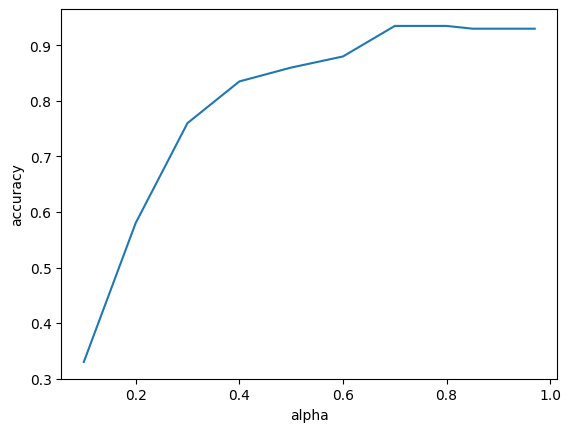

In [41]:
plt.plot(alpha, scores)
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()


according to this figure as alpha increases the accuracy increases 

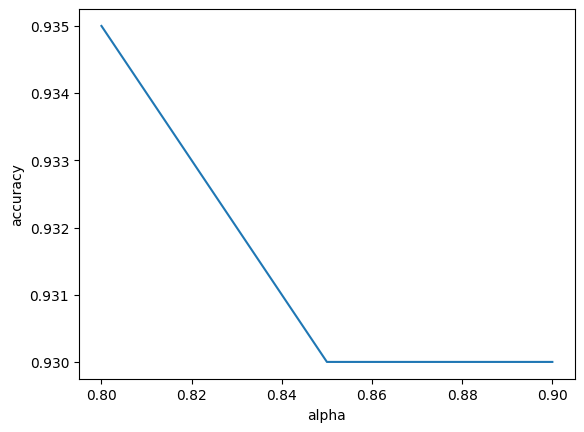

In [42]:
plt.plot(alpha[7:10], scores[7:10])
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.show()
